Q1 (25th percentile): 27.96176470588236
Q3 (75th percentile): 37.97826086956522
Interquartile Range (IQR): 10.01649616368286


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


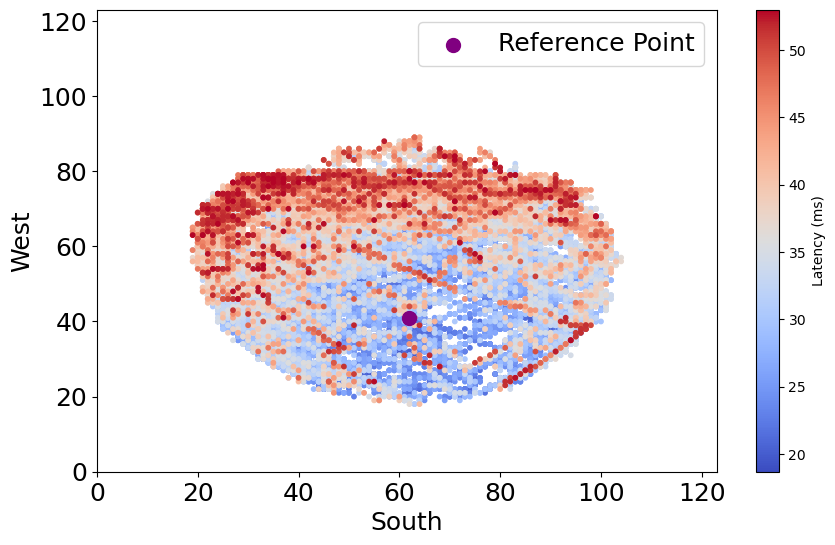

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Load your CSV file
file_path = 'matched_satellite_data.csv'  # Update this path to your actual CSV file path
data = pd.read_csv(file_path)

# Convert the 'Timestamp' column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Calculate the interquartile range (IQR) for PingTime
Q1 = data['PingTime'].quantile(0.25)
Q3 = data['PingTime'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"Interquartile Range (IQR): {IQR}")

# Filter out the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = data[(data['PingTime'] >= lower_bound) & (data['PingTime'] <= upper_bound)]

# Sort the filtered data by PingTime so that higher ping times are plotted on top
filtered_data = filtered_data.sort_values(by='PingTime')

# Plotting the points for the filtered dataset
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(filtered_data['X'], filtered_data['Y'], c=filtered_data['PingTime'], cmap='coolwarm', s=10)
plt.colorbar(sc, label='Latency (ms)')

# Highlight the specific point
tilt=27.3
ax.scatter(62, 62-(tilt/(80/62)), color='purple', s=100, label='Reference Point')

ax.set_xlabel('South', fontsize=18)
ax.set_ylabel('West', fontsize=18)
# ax.set_title('Latency Distribution in Trajectory Plot', fontsize=18)
ax.set_xlim(0, 123)
ax.set_ylim(0, 123)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.savefig("dis.eps",format='eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


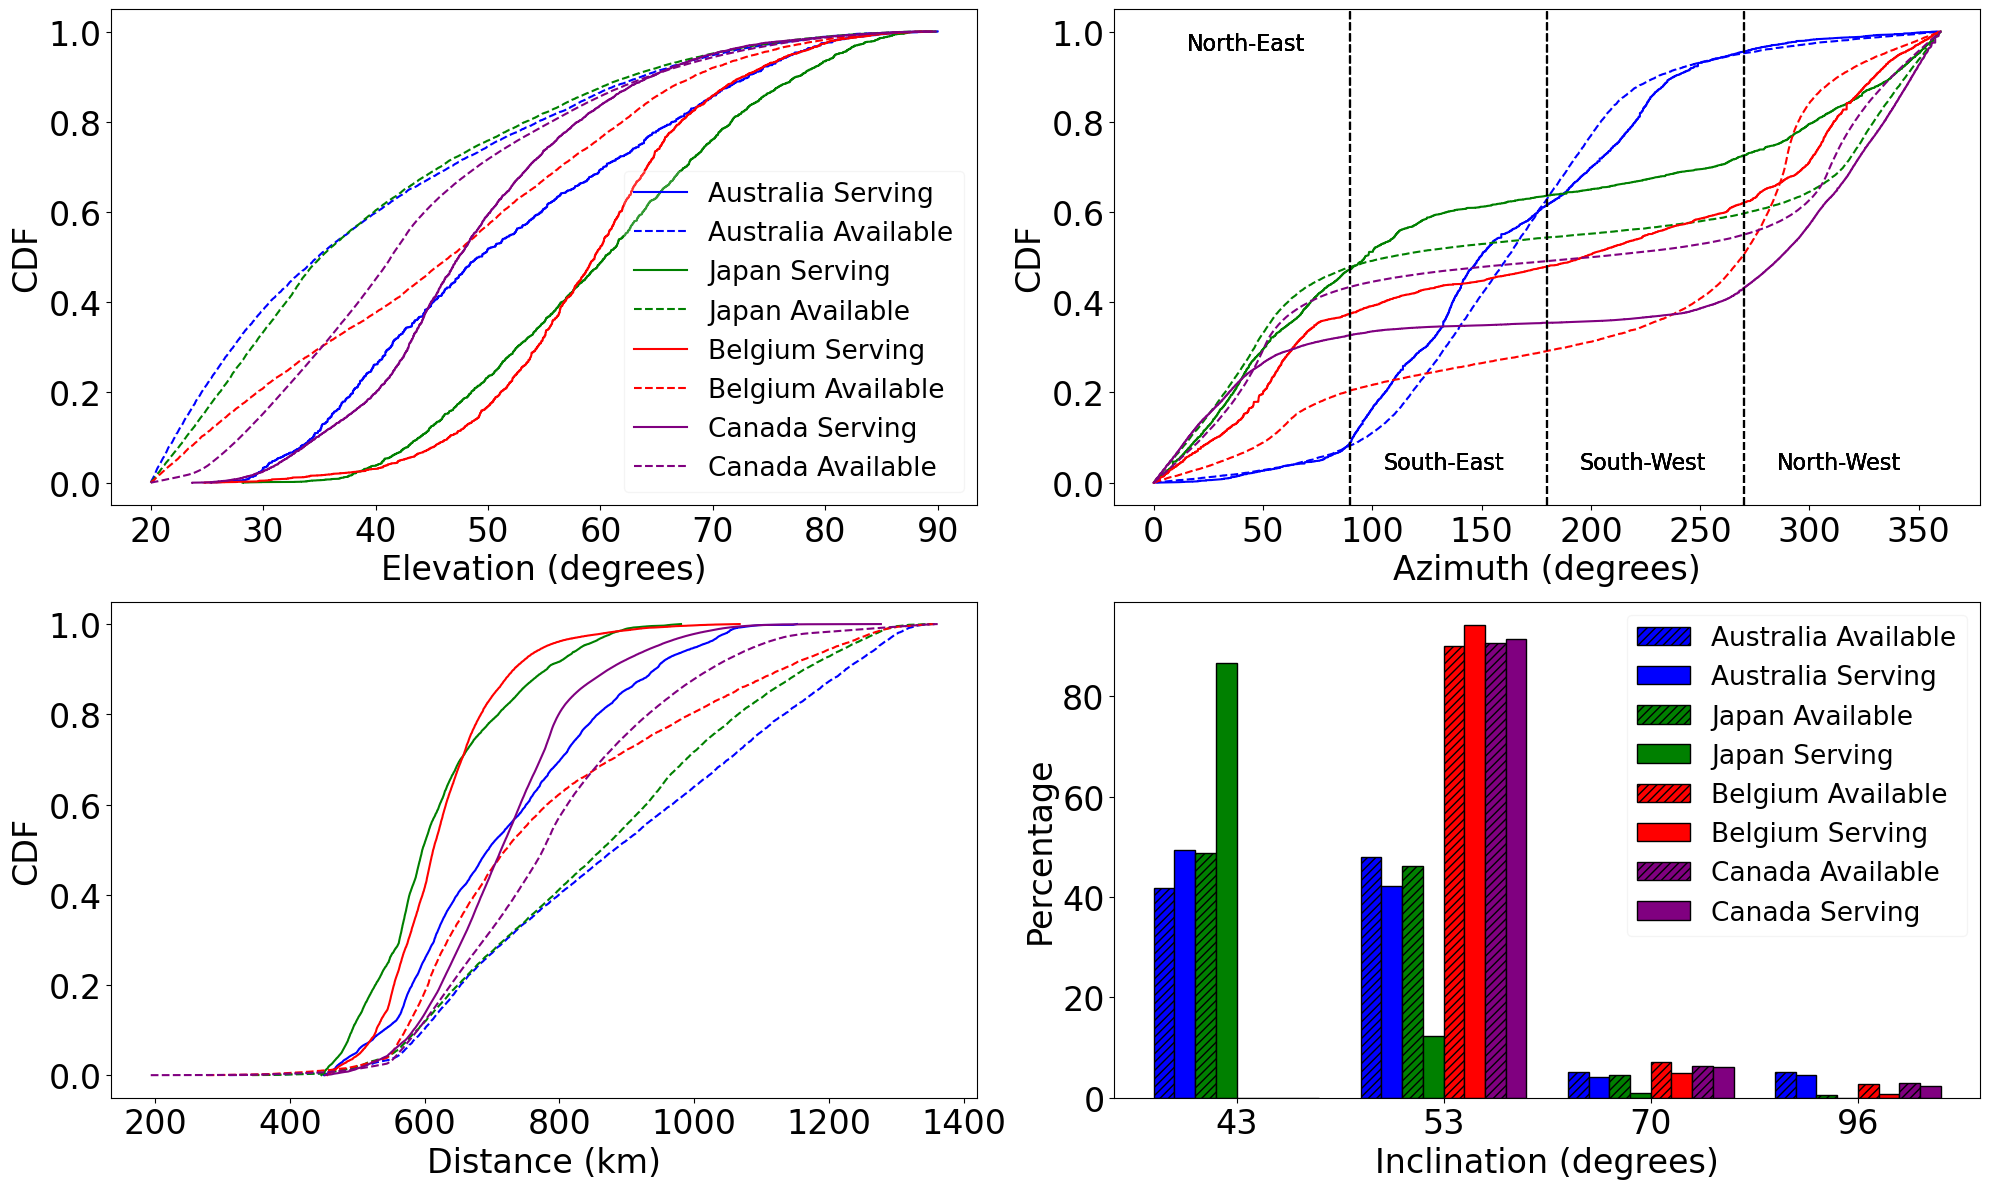

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from skyfield.api import load, EarthSatellite
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

def adjust_azimuths(azimuths, adjustment):
    adjusted_azimuths = [(az + adjustment) % 360 for az in azimuths]
    return adjusted_azimuths

def categorize_inclinations(inclinations):
    categories = {'40-50': 0, '50-60': 0, '60-80': 0, '80-100': 0}
    for inc in inclinations:
        if 40 <= inc < 50:
            categories['40-50'] += 1
        elif 50 <= inc < 60:
            categories['50-60'] += 1
        elif 60 <= inc < 80:
            categories['60-80'] += 1
        elif 80 <= inc <= 100:
            categories['80-100'] += 1
    total = sum(categories.values())
    for key in categories:
        categories[key] = (categories[key] / total) * 100  # Convert to percentage
    return categories

def categorize_azimuths(azimuths):
    categories = {'North-East': 0, 'North-West': 0, 'South-East': 0, 'South-West': 0}
    for az in azimuths:
        if 0 <= az < 90:
            categories['North-East'] += 1
        elif 90 <= az < 180:
            categories['South-East'] += 1
        elif 180 <= az < 270:
            categories['South-West'] += 1
        elif 270 <= az < 360:
            categories['North-West'] += 1
    total = sum(categories.values())
    for key in categories:
        categories[key] = (categories[key] / total) * 100  # Convert to percentage
    return categories

def plot_cdfs_and_histograms(fov_data_dict, matched_data_dict):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    colors = {'Australia': 'blue', 'Japan': 'green', 'Belgium': 'red', 'Canada': 'purple'}
    adjustments = {'Australia': 159, 'Japan': 8.8, 'Belgium': -43, 'Canada': -2.5}
    regions = list(fov_data_dict.keys())

    # Prepare data for inclination histograms
    incl_categories = ['40-50', '50-60', '60-80', '80-100']
    azimuth_categories = ['North-East', 'South-East', 'South-West', 'North-West']
    incl_fov_counts = {region: categorize_inclinations([sat['Inclination'] for entry in fov_data_dict[region] for sat in entry['Satellites']]) for region in regions}
    incl_matched_counts = {region: categorize_inclinations(matched_data_dict[region]['Inclination'].dropna()) for region in regions}

    bar_width = 0.1  # narrower bar width
    x = np.arange(len(incl_categories))  # the label locations

    for i, region in enumerate(regions):
        matched_data = matched_data_dict[region]
        
        # Prepare FOV data
        azimuths_fov = []
        elevations_fov = []
        distances_fov = []

        for entry in fov_data_dict[region]:
            for sat in entry['Satellites']:
                azimuths_fov.append(sat['Azimuth'])
                elevations_fov.append(sat['Elevation'])
                distances_fov.append(sat['Distance'])

        # Adjust azimuths
        azimuth_sorted_fov, azimuth_cdf_fov = calculate_cdf(azimuths_fov)
        elevation_sorted_fov, elevation_cdf_fov = calculate_cdf(elevations_fov)
        distance_sorted_fov, distance_cdf_fov = calculate_cdf(distances_fov)

        # Prepare matched data
        matched_azimuths = adjust_azimuths(matched_data['Azimuth'].dropna(), adjustments[region])
        matched_elevations = matched_data['Elevation'].dropna()
        matched_distances = matched_data['Distance'].dropna()

        azimuth_sorted_matched, azimuth_cdf_matched = calculate_cdf(matched_azimuths)
        elevation_sorted_matched, elevation_cdf_matched = calculate_cdf(matched_elevations)
        distance_sorted_matched, distance_cdf_matched = calculate_cdf(matched_distances)

        # Plot elevation
        axes[0, 0].plot(elevation_sorted_matched, elevation_cdf_matched, linestyle='-', color=colors[region], label=f'{region} Serving')
        axes[0, 0].plot(elevation_sorted_fov, elevation_cdf_fov, linestyle='--', color=colors[region], label=f'{region} Available')
        axes[0, 0].set_xlabel('Elevation (degrees)', fontsize=24)
        axes[0, 0].set_ylabel('CDF', fontsize=24)
        axes[0, 0].tick_params(axis='both', which='major', labelsize=24)
        axes[0, 0].legend(fontsize=19, framealpha=0.2)

        # Plot azimuth
        axes[0, 1].plot(azimuth_sorted_matched, azimuth_cdf_matched, linestyle='-', color=colors[region], label=f'{region} Serving')
        axes[0, 1].plot(azimuth_sorted_fov, azimuth_cdf_fov, linestyle='--', color=colors[region], label=f'{region} Available')
        axes[0, 1].set_xlabel('Azimuth (degrees)', fontsize=24)
        axes[0, 1].set_ylabel('CDF', fontsize=24)
        axes[0, 1].tick_params(axis='both', which='major', labelsize=24)

        axes[0, 1].text(0 + 15, 1, 'North-East', rotation=0, verticalalignment='top', fontsize=16, color='black')
        for azimuth, label in zip([90, 180, 270], azimuth_categories[1:]):
            axes[0, 1].axvline(x=azimuth, linestyle='--', color='black')
            axes[0, 1].text(azimuth + 15, 0.02, label, rotation=0, verticalalignment='bottom', fontsize=16, color='black')

        # Plot distance
        axes[1, 0].plot(distance_sorted_matched, distance_cdf_matched, linestyle='-', color=colors[region], label=f'{region} Serving')
        axes[1, 0].plot(distance_sorted_fov, distance_cdf_fov, linestyle='--', color=colors[region], label=f'{region} Available')
        axes[1, 0].set_xlabel('Distance (km)', fontsize=24)
        axes[1, 0].set_ylabel('CDF', fontsize=24)
        axes[1, 0].tick_params(axis='both', which='major', labelsize=24)

    # Plot inclination histogram
    bar_width = 0.1  # the width of the bars
    x = np.arange(len(incl_categories))  # the label locations

    for i, region in enumerate(regions):
        incl_fov_vals = [incl_fov_counts[region][cat] for cat in incl_categories]
        incl_matched_vals = [incl_matched_counts[region][cat] for cat in incl_categories]

        positions = x + i * bar_width * 2  # Adjust positions to prevent overlap
        axes[1, 1].bar(positions - bar_width / 2, incl_fov_vals, bar_width, label=f'{region} Available', color=colors[region], hatch='////', edgecolor='black')  # Denser hatch pattern
        axes[1, 1].bar(positions + bar_width / 2, incl_matched_vals, bar_width, label=f'{region} Serving', color=colors[region], edgecolor='black')  # No transparency, fully opaque

    # Set x-axis ticks
    positions_all = np.arange(len(incl_categories)) + bar_width * (len(regions) - 1)
    axes[1, 1].set_xticks(positions_all)
    incl_categories = ['43', '53', '70', '96']
    axes[1, 1].set_xticklabels(incl_categories)

    axes[1, 1].set_xlabel('Inclination (degrees)', fontsize=24)
    axes[1, 1].set_ylabel('Percentage', fontsize=24)
    axes[1, 1].tick_params(axis='both', which='major', labelsize=24)
    axes[1, 1].legend(fontsize=19, framealpha=0.2)

    plt.tight_layout()
    plt.savefig('CDFs_and_Histograms_All_Regions.eps', format='eps')
    plt.show()

# Load matched data
matched_bri = pd.read_csv('first_bri.csv')
matched_kna = pd.read_csv('first_kna.csv')
matched_ucl = pd.read_csv('first_ucl.csv')
matched_vic = pd.read_csv('first_vic.csv')

# Convert Timestamp to datetime
matched_bri['Timestamp'] = pd.to_datetime(matched_bri['Timestamp'])
matched_kna['Timestamp'] = pd.to_datetime(matched_kna['Timestamp'])
matched_ucl['Timestamp'] = pd.to_datetime(matched_ucl['Timestamp'])
matched_vic['Timestamp'] = pd.to_datetime(matched_vic['Timestamp'])

# Load fov_data from JSON files
with open('fov_data_bri.json', 'r') as file:
    fov_data_bri = json.load(file)

with open('fov_data_kna.json', 'r') as file:
    fov_data_kna = json.load(file)

with open('fov_data_ucl.json', 'r') as file:
    fov_data_ucl = json.load(file)

with open('fov_data_vic.json', 'r') as file:
    fov_data_vic = json.load(file)

# Load TLE data for inclination
tle_data_url = 'gp.php'
satellites = load.tle_file(tle_data_url)
inclinations = {sat.name: sat.model.inclo * 180.0 / np.pi for sat in satellites}

# Add inclination data to the matched dataframes
matched_bri['Inclination'] = matched_bri['Connected_Satellite'].map(inclinations)
matched_kna['Inclination'] = matched_kna['Connected_Satellite'].map(inclinations)
matched_ucl['Inclination'] = matched_ucl['Connected_Satellite'].map(inclinations)
matched_vic['Inclination'] = matched_vic['Connected_Satellite'].map(inclinations)

# Dictionary of data
fov_data_dict = {
    'Australia': fov_data_bri,
    'Japan': fov_data_kna,
    'Belgium': fov_data_ucl,
    'Canada': fov_data_vic
}

matched_data_dict = {
    'Australia': matched_bri,
    'Japan': matched_kna,
    'Belgium': matched_ucl,
    'Canada': matched_vic
}

# Plot CDFs and histograms for all regions
plot_cdfs_and_histograms(fov_data_dict, matched_data_dict)


C:\Users\ALI\AppData\Local\Temp\ipykernel_16080\4053677893.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['IntervalStart'] = filtered_data['Timestamp'].apply(assign_interval)


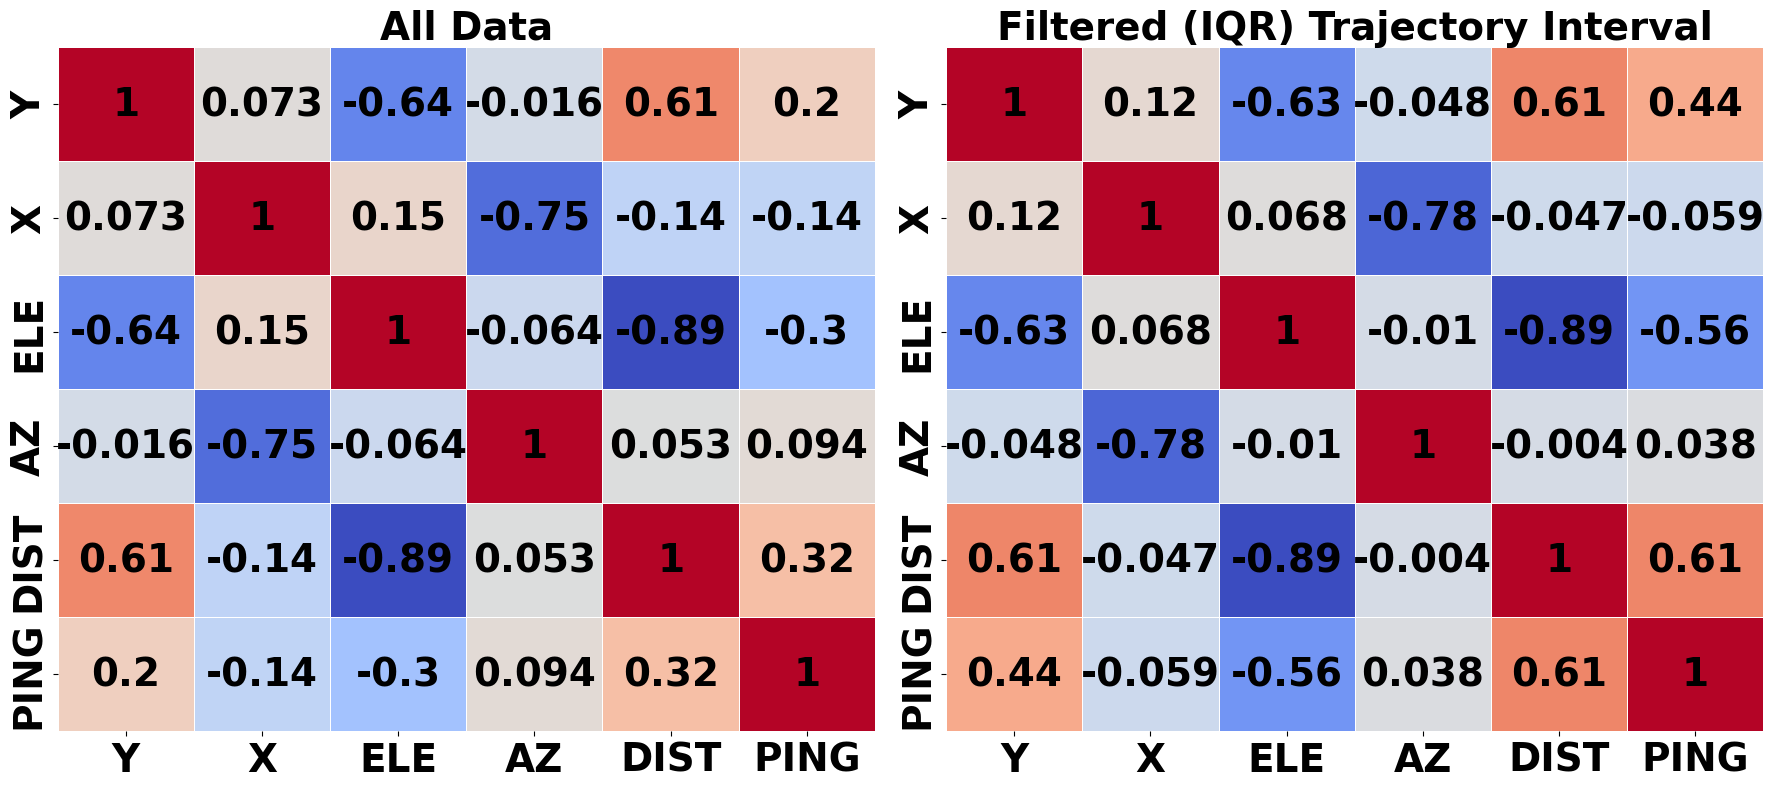

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set up the font type for PDF/PS outputs and save as EPS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load the data
file_path = 'matched_satellite_data.csv'  # Update this with the correct file path
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Function to assign intervals based on seconds
def assign_interval(ts):
    if ts.second >= 12 and ts.second < 27:
        return ts - pd.to_timedelta(ts.second - 12, unit='s')
    elif ts.second >= 27 and ts.second < 42:
        return ts - pd.to_timedelta(ts.second - 27, unit='s')
    elif ts.second >= 42 and ts.second < 57:
        return ts - pd.to_timedelta(ts.second - 42, unit='s')
    else:
        return ts - pd.to_timedelta(ts.second - 57, unit='s')

# Apply the function to create interval start timestamps
data['IntervalStart'] = data['Timestamp'].apply(assign_interval)

# Group by interval start and calculate the mean for each interval, excluding non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
aggregated_data = data.groupby('IntervalStart')[numeric_columns].mean().reset_index()
aggregated_data = aggregated_data.drop(columns=['IntervalStart'])

# Filter data based on the IQR of the latency (PingTime column)
Q1 = data['PingTime'].quantile(0.25)
Q3 = data['PingTime'].quantile(0.75)
IQR = Q3 - Q1

filtered_data = data[(data['PingTime'] >= (Q1 - 1.5 * IQR)) & (data['PingTime'] <= (Q3 + 1.5 * IQR))]

# Apply the interval function to create interval start timestamps for the filtered data
filtered_data['IntervalStart'] = filtered_data['Timestamp'].apply(assign_interval)

# Group by interval start and calculate the mean for each interval, excluding non-numeric columns
filtered_aggregated_data = filtered_data.groupby('IntervalStart')[numeric_columns].mean().reset_index()
filtered_aggregated_data = filtered_aggregated_data.drop(columns=['IntervalStart'])

# Calculate correlation matrices
corr_matrix_raw = data[numeric_columns].corr().round(3)
corr_matrix_filtered_aggregated = filtered_aggregated_data.corr().round(3)

# Define the new order for the correlation matrix
desired_column_order = [ 'Y', 'X', 'Elevation', 'Azimuth', 'Distance','PingTime']
custom_labels = ['Y', 'X', 'ELE', 'AZ', 'DIST', 'PING']

# Reorder the columns in the correlation matrices
corr_matrix_raw = corr_matrix_raw.reindex(desired_column_order, axis=0).reindex(desired_column_order, axis=1)
corr_matrix_filtered_aggregated = corr_matrix_filtered_aggregated.reindex(desired_column_order, axis=0).reindex(desired_column_order, axis=1)

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First heatmap (raw data)
sns.heatmap(corr_matrix_raw, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[0], cbar=False,
            annot_kws={"size": 28, "color": "black", "weight": "bold"})
axes[0].set_title('All Data', fontsize=28, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=28)
axes[0].set_xticklabels(custom_labels, fontsize=28, fontweight='bold')
axes[0].set_yticklabels(custom_labels, fontsize=28, fontweight='bold')

# Second heatmap (filtered with IQR and averaging intervals)
sns.heatmap(corr_matrix_filtered_aggregated, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[1], cbar=False,
            annot_kws={"size": 28, "color": "black", "weight": "bold"})
axes[1].set_title('Filtered (IQR) Trajectory Interval', fontsize=28, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=28)
axes[1].set_xticklabels(custom_labels, fontsize=28, fontweight='bold')
axes[1].set_yticklabels(custom_labels, fontsize=28, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as EPS
plt.savefig('cor.eps', format='eps', bbox_inches='tight')

# Display the plots
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


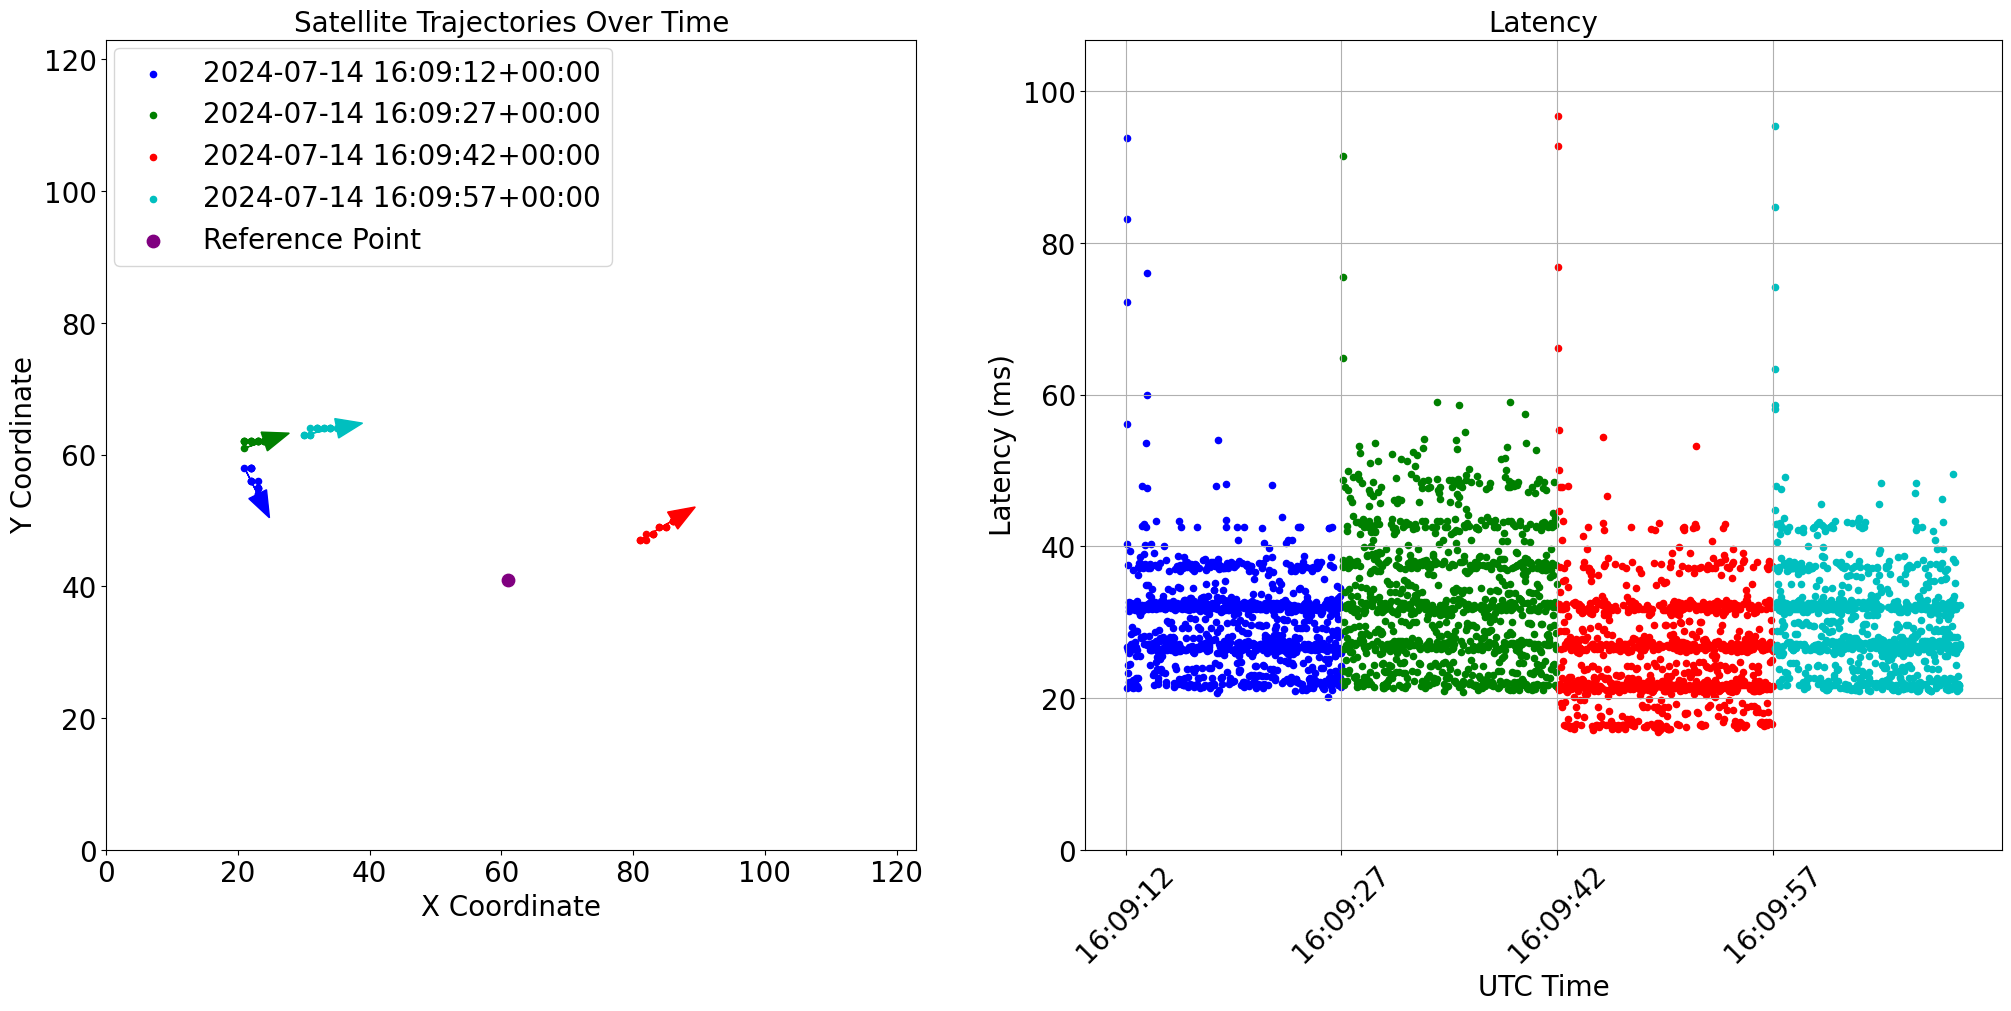

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def plot_coordinates_and_ping(filename_coordinates, filename_ping, start_time, end_time):
    # Read the data from the CSV file with correct headers and comma separator
    data_coordinates = pd.read_csv(filename_coordinates, sep=',', header=None, names=['Timestamp', 'Y', 'X'])
    
    # Convert 'Timestamp' to datetime for easy filtering and make them timezone-aware
    data_coordinates['Timestamp'] = pd.to_datetime(data_coordinates['Timestamp']).dt.tz_localize('UTC')
    
    # Filter data by the specified timestamp range
    data_coordinates = data_coordinates[(data_coordinates['Timestamp'] >= start_time) & (data_coordinates['Timestamp'] <= end_time)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'grey', 'lime', 'indigo', 'turquoise']
    color_index = 0
    
    # Observer's location
    observer_x, observer_y = 61, 41  # Observer's location in pixel coordinates (swap x and y for correct azimuth calculation)
    pixel_to_degrees = 80/61  # Conversion factor from pixels to degrees, adjust as needed

    # Define the start seconds for each 15-second interval
    interval_starts = [12, 27, 42, 57]

    interval_colors = {}  # To store colors for each interval

    # Group data by each unique minute and process intervals within those minutes
    for minute in data_coordinates['Timestamp'].dt.floor('T').unique():
        for interval_start in interval_starts:
            interval_start_time = minute + pd.to_timedelta(interval_start, unit='s')
            interval_end_time = interval_start_time + pd.to_timedelta(15, unit='s')
            interval_data = data_coordinates[(data_coordinates['Timestamp'] >= interval_start_time) &
                                             (data_coordinates['Timestamp'] < interval_end_time)]
            if interval_data.empty:
                continue
            
            coordinates = interval_data[['X', 'Y']].values.tolist()
            
            # Calculate mean coordinates
            mean_x = np.mean([coord[0] for coord in coordinates])
            mean_y = np.mean([coord[1] for coord in coordinates])
            
            # Compute the azimuth and elevation from mean coordinates
            dx, dy = mean_x - observer_x, mean_y - observer_y
            radius = np.sqrt(dx**2 + dy**2) * pixel_to_degrees
            angle = np.degrees(np.arctan2(dx, dy))  # Swap dx and dy for correct azimuth calculation
            elevation = 90 - radius

            # Plot the points
            x, y = zip(*coordinates)
            current_color = colors[color_index % len(colors)]
            ax1.scatter(x, y, color=current_color, label=f"{interval_start_time}", s=20)
            interval_colors[(interval_start_time, interval_end_time)] = current_color

            # Draw an arrow from the first to the last point in the interval
            start_point = coordinates[0]
            end_point = coordinates[-1]
            arrow_dx = end_point[0] - start_point[0]
            arrow_dy = end_point[1] - start_point[1]
            ax1.arrow(start_point[0], start_point[1], arrow_dx, arrow_dy, 
                      head_width=3, head_length=4, fc=current_color, ec=current_color)

            # Increment to next color
            color_index += 1

    if color_index == 0:
        print("No data found in the specified time range.")

    ax1.set_xlim(0, 123)
    ax1.set_ylim(0, 123)
    ax1.set_aspect('equal', adjustable='box')  # Set the aspect ratio to be equal
    ax1.scatter(observer_x, observer_y, color='purple', s=80, label='Reference Point')
    ax1.set_xlabel('X Coordinate', fontsize=20)
    ax1.set_ylabel('Y Coordinate', fontsize=20)
    ax1.set_title('Satellite Trajectories Over Time', fontsize=20)
    ax1.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), borderaxespad=0, fontsize=20)  # Increase legend font size
    ax1.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size

    # Plot the ping times in the right plot
    # Loading the file content
    with open(filename_ping, 'r') as file:
        lines = file.readlines()

    # Extracting the timestamp and the ping time with more robust parsing
    data_ping = []
    for line in lines:
        match = re.search(r'\[(\d+\.\d+)\] 64 bytes from .+ time=(\d+\.\d+)', line)
        if match:
            timestamp = float(match.group(1))
            ping_time = float(match.group(2))
            data_ping.append([timestamp, ping_time])

    # Creating a DataFrame
    df_ping = pd.DataFrame(data_ping, columns=['Timestamp', 'Ping Time'])

    # Converting the timestamps to UTC
    df_ping['UTC Time'] = pd.to_datetime(df_ping['Timestamp'], unit='s', utc=True)

    # Filter the DataFrame to include only the specified time range
    filtered_df_ping = df_ping[(df_ping['UTC Time'] >= start_time) & (df_ping['UTC Time'] <= end_time)]

    # Generating x-ticks at specific seconds of each minute
    xticks = pd.date_range(start=start_time, end=end_time, freq='S')
    xticks = xticks[xticks.second.isin([12, 27, 42, 57])]

    # Adding the ping times plot
    for (interval_start_time, interval_end_time), color in interval_colors.items():
        interval_ping_data = filtered_df_ping[(filtered_df_ping['UTC Time'] >= interval_start_time) &
                                              (filtered_df_ping['UTC Time'] < interval_end_time)]
        ax2.scatter(interval_ping_data['UTC Time'], interval_ping_data['Ping Time'], color=color, marker='o', s=20)  # s controls the size of the markers

    ax2.set_xlabel('UTC Time', fontsize=20)
    ax2.set_ylabel('Latency (ms)', fontsize=20)
    ax2.set_title('Latency', fontsize=20)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks.strftime('%H:%M:%S'), rotation=45, fontsize=20)  # Increase tick label font size
    ax2.grid(True)
    ax2.set_ylim(0, filtered_df_ping['Ping Time'].max() + 10)  # Adjust y-axis limit for better visualization
    ax2.set_aspect('auto', adjustable='box')  # Set the aspect ratio to be auto
    ax2.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size
    # ax2.legend(fontsize=22)  # Increase legend font size

    # Save the plot as an EPS file
    plt.savefig("tr.eps", format='eps')
    plt.show()

# Example usage with hardcoded start and end times
if __name__ == "__main__":
    filename_coordinates = 'white_pixel_coordinates_xor714.csv'  # Replace with your actual CSV file path
    filename_ping = 'longping714.txt'  # Replace with your actual ping file path
    start_time = pd.to_datetime("2024-07-14 16:09:12", utc=True)
    end_time = pd.to_datetime("2024-07-14 16:10:10", utc=True)
    
    plot_coordinates_and_ping(filename_coordinates, filename_ping, start_time, end_time)


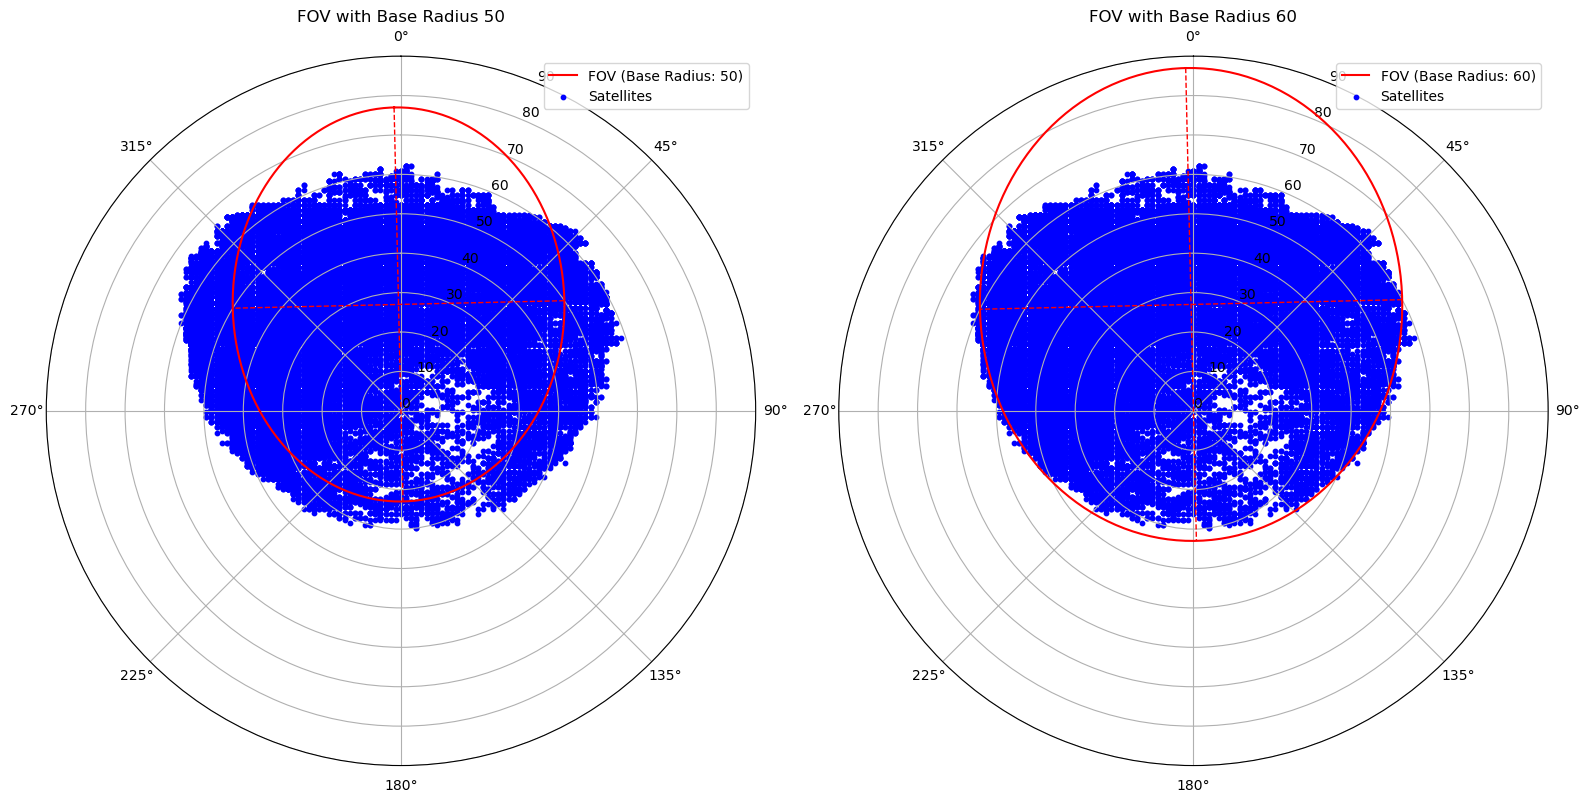

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

def rotate_points(x, y, angle):
    """Rotates points by the given angle."""
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(ax, tilt_deg, rotation_deg, base_radius, azimuths, elevations):
    """Draws the FOV ellipse with given tilt, rotation, and base radius, and adds satellite points."""
    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    # FOV ellipse and axes
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r', label=f'FOV (Base Radius: {base_radius})')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    # Scatter satellite positions (Elevation, Azimuth from first_vic.csv)
    scatter_r = 90 - elevations  # Polar plot r (90 - Elevation degrees)
    scatter_theta = np.radians(azimuths)  # Polar plot theta (Azimuth in radians)
    ax.scatter(scatter_theta, scatter_r, color='blue', label='Satellites', s=10)  # Reduced size (s=20)

    ax.legend(loc='upper right')

if __name__ == "__main__":
    # Load the first_vic.csv file (assuming it's in the same directory)
    data = pd.read_csv('first_vic.csv')

    # Extract Azimuth and Elevation from the CSV file
    azimuths = data['Azimuth']
    elevations = data['Elevation']

    # Create subplots for side-by-side comparison
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16, 8))

    # Draw FOV with base radius 50
    draw_fov(axes[0], tilt_deg=27, rotation_deg=-1.3, base_radius=50, azimuths=azimuths, elevations=elevations)
    axes[0].set_title('FOV with Base Radius 50')

    # Draw FOV with base radius 60
    draw_fov(axes[1], tilt_deg=27, rotation_deg=-1.3, base_radius=60, azimuths=azimuths, elevations=elevations)
    axes[1].set_title('FOV with Base Radius 60')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()
